# Introduction

Today we'll continue on with time series, we'll be introduced to **decision trees** and **random forests**, and, if we have time, we'll cover **bagging** and **boosting** as concepts. 

## Libraries Used

In [26]:
import os
import sys

import pandas as pd
# import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## Paired Programming –– Refresher

Let's try and write functions for both the F-value and the Adjusted R-squared.

In [29]:
TSS = 1150

RSS = 250

Reg_SS = 900


def f_value(tss = TSS, rss = RSS, reg_ss = Reg_SS, k = 3, n = 500):
    
    f_value = ((reg_ss/k)/(rss/(n-k-1)))
    
    return f_value

In [31]:
f_stat()

595.2

In [38]:
def R_sq(rss = RSS, tss = TSS, n = 500, k = 2):
    
    R_sq = 1 - (rss/tss)
    
    return R_sq

In [39]:
R_sq()

0.782608695652174

## Adjusted R-squared

Adjusted R-squared penalizes our model for every additional explanatory variable that we include. Let try and write it as a function:

In [44]:
def adjust_R_sq(rss = RSS, tss = TSS, n = 500, k = 100):
    
    adj_R_sq = 1 - ((rss/(n-k-1))/(tss/(n-1)))
    
    return adj_R_sq

In [45]:
adjust_R_sq()

0.7281246594747739

In [27]:
data = pd.read_csv('/Users/MattMecca/Documents/Graduate School/2nd Semester Courses/Applied Statistics & Econometrics II/Data Folder/HF Exch Rate Data.csv')
data.head()



,index,Date,eur_cur,gbp_cur,cny_cur,jpy_cur
0,1,9/18/16,1.1155,1.3002,6.6634,102.20
1,2,9/18/16,1.1156,1.3000,6.6658,102.20
2,3,9/18/16,1.1158,1.3003,6.6684,102.22
3,4,9/18/16,1.1154,1.3004,6.6683,102.26
4,5,9/18/16,1.1158,1.3008,6.6680,102.22


## Time Series in Python

The first hour of this lecture is going to be an adapted version of "Time Series Analysis (TSA) in Python - Linear Models to GARCH" –– http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016. We'll go through it together. I think it'll shed a lot of light on the topics we discussed in our last class.

### White Noise and Random Walks


**White noise** is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially UNcorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it. Below I introduce a convenience function for plotting the time series and analyzing the serial correlation visually. This code was adapted from the blog Seanabu.com

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

We can model a white noise process easily and output the TS plot for visual inspection. 

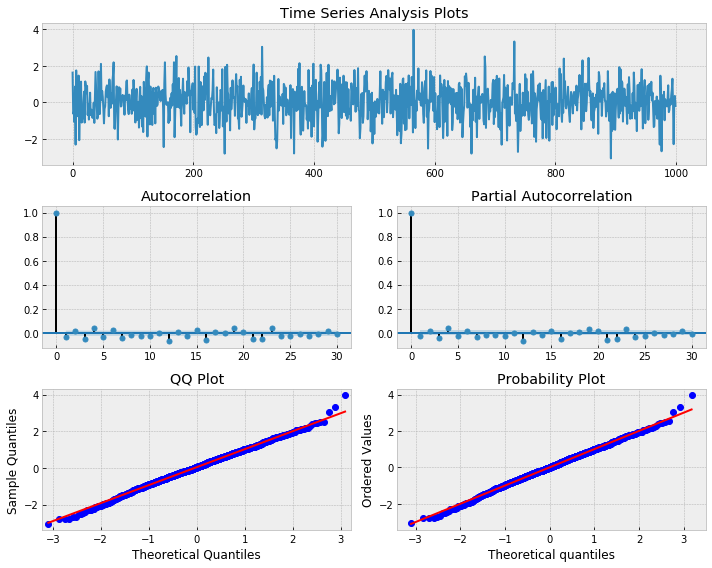

In [28]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

## Random Walk Model

The significance of a random walk is that it is non-stationary because the covariance between observations is time-dependent. If the TS we are modeling is a random walk it is unpredictable.

Let's simulate a random walk using the "numpy.random.normal(size=our_sample_size)" function to sample from the standard normal distribution. 

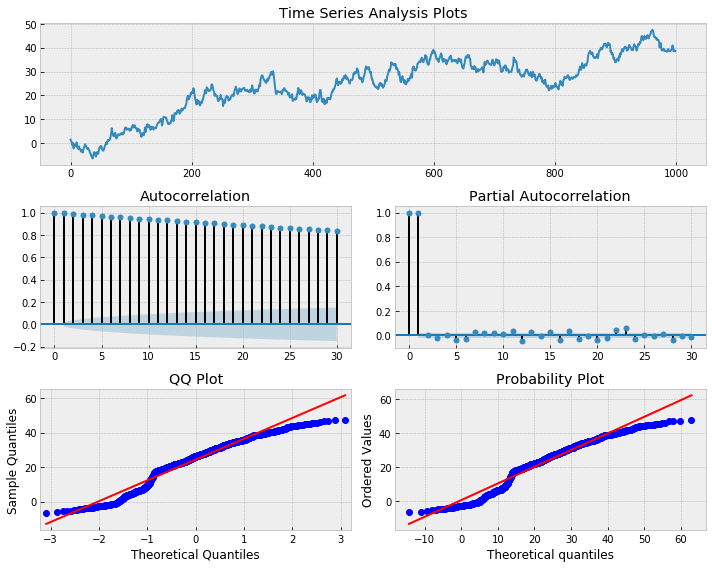

In [9]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. Let's find out if the random walk model is a good fit for our simulated data. Recall that a random walk is xt = xt-1 + wt. Using algebra we can say that xt - xt-1 = wt. Thus the first differences of our random walk series should equal a white noise process! We can use the "np.diff()" function on our TS and see if this holds. 

### First difference of simulated Random Walk series


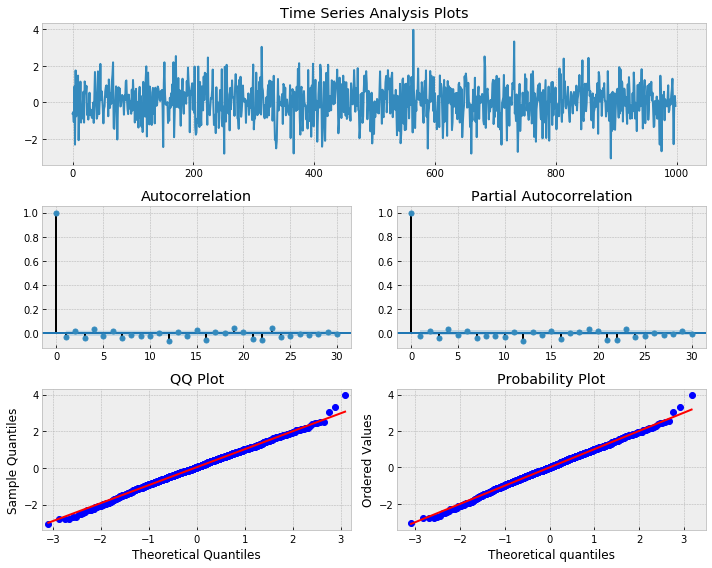

In [10]:
_ = tsplot(np.diff(x), lags=30)


Our definition holds as this looks exactly like a white noise process. What if we fit a random walk to the first difference of EUROs?



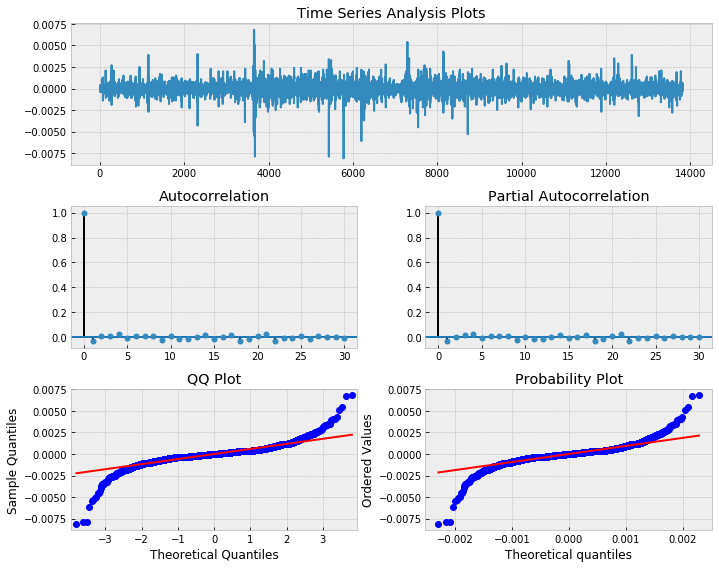

In [17]:
# First difference of SPY prices
_ = tsplot(np.diff(data.eur_cur), lags=30)

It's somewhat similar to white noise. However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

### Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. 

The basic equation uses TIME (or 't') as a predictor (or 'x')


In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time. An example could be a company's sales that increase by the same amount at each time step.  Let's look at a contrived example below. In this simulation we assume Firm ABC sales regardless of time are -$50.00 (beta 0 or the intercept term) and +$25.00 (beta 1) at every time step. 

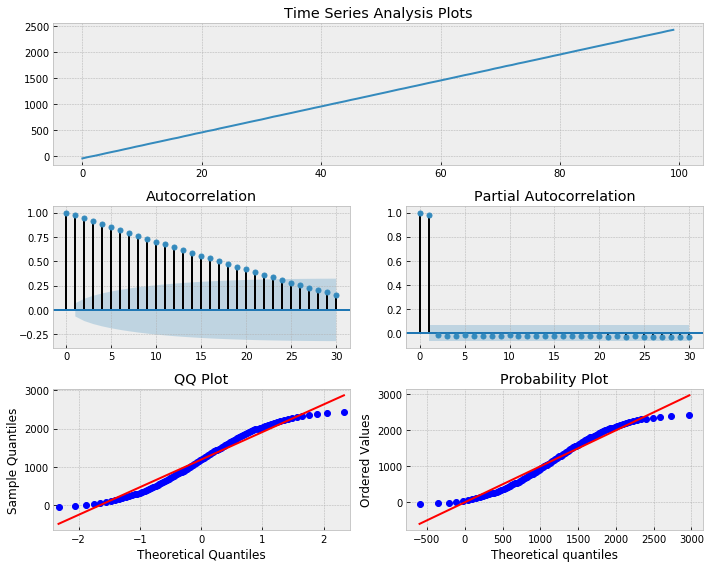

In [19]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

lags = 30
w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=lags)  

### Log-Linear Models


These models are similar to linear models except that the data points form an exponential function that represent a constant rate of change with respect to each time step. For example, firm ABC's sales increasing X% at each time step. When plotting the simulated sales data you get a curve that looks like this:

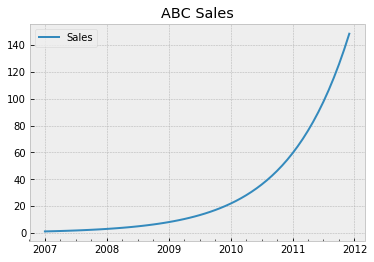

In [20]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

We can then transform the data by taking the natural logarithm of sales. Now a linear regression is a much better fit to the data.

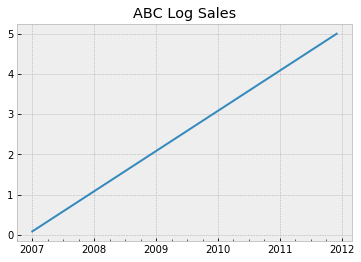

In [21]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

These models have a fatal weakness as discussed previously. They assume serially UNcorrelated errors, which as we have seen in the linear model example is not true. In real life, TS data usually violates our stationary assumptions which motivates our progression to autoregressive models.

### Autoregressive Models - AR(p)


When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. See board for formula.


When you describe the "order" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model. For example an AR(2) model or second-order autoregressive model is constructed how we wrote it on the board.

Here, alpha (a) is the coefficient, and omega (w) is a white noise term. Alpha cannot equal zero in an AR model. Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary. 

Let's simulate an AR(1) model with alpha set equal to 0.6

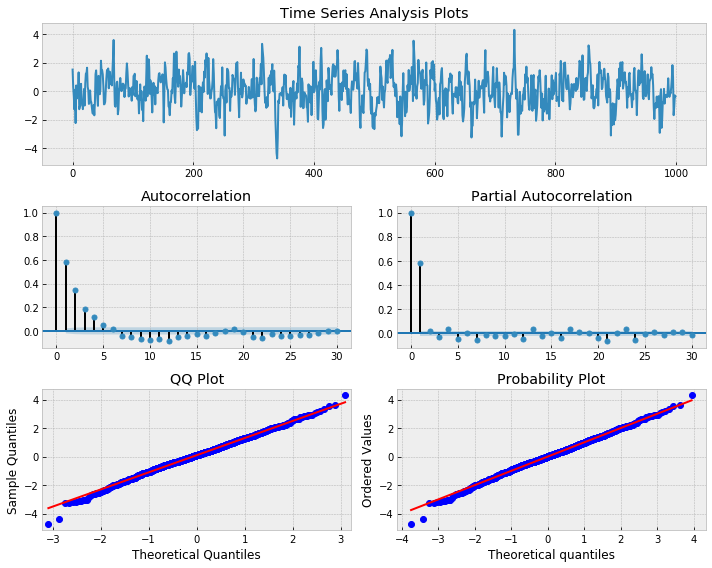

In [46]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

## Paired Programming

Let's try and write an autocorrelation function for the below time series:

In [50]:
time_series = [2, 3, 3.5, 3, 4, 5.5, 6.2, 5.3, 6.9]

ts_mean = np.mean(time_series)

ts_mean

4.377777777777777

In [63]:
sum1 = 0

for t_1, t_2 in enumerate(time_series[(2+1):]):
    sum1 += t_2, (t_1-2) * t_2

TypeError: unsupported operand type(s) for +=: 'int' and 'tuple'

In [ ]:
def acf(ts = time_series, k = 2, y_bar = ts_mean):
    
    sum1 = 0
    sum2 = 0
    
    for t_1, t_2 in enumerate(ts[((k+1):]):
        
        sum1 += t_2[-k] * t_2
                                 
                                 
        
        
        
        

In [73]:
def acf(ts = time_series, k = 1, y_bar = ts_mean):
   
   numerator = 0
   denominator = 0

   for t in range(k, len(time_series)):
        numerator += (time_series[t - k] - y_bar)* (time_series[t] - y_bar)

   for t in range(0, len(time_series)):
        denominator += (time_series[t] - y_bar)**2

   acf = numerator / denominator

   return acf

In [80]:
acf(k = 0)

1.0

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [47]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))

CPU times: user 37.4 s, sys: 1.15 s, total: 38.5 s
Wall time: 23.1 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data.

### Decision Tree Regression vs Decision Tree Classification

The primary difference between these two is that, with **decision tree regression**, the response, or our 'y', variable is **CONTINUOUS** (e.g., 1.8223, 5, -123.340940, ...); with **decision tree classification**, the response, or our 'y', variable is **CATEGORICAL**, or **DISCRETE** (e.g., Yes, No, Blue, Green, etc.) –– they're allocated to one of any number of *buckets*.



## The Gini Index, Cross-Entropy, and the Misclassification Error

Show proof ––> Problem number 27

* Proofs are why we ought to "take the mathematician's word for it." Mathematicians, generally speaking, are skeptical people. If there's a widely distributed **THEOREM** in mathematics, you can bet that its proven time and time again (and in more than a few  ways). There are times that we can reason and make sense of how and why certain formulas work, but, for the most part, we are not going to try and work out every theorem's proof; we are simply going to "take the mathematician's word for it."

## Paired Programming

With the below data set, let's write a function that calculates the Gini Index.

In [ ]:
new_data = [(0.33, 0.67), (0.22, 0.78), (0.01, 0.99), (0.86, 0.14)]

### Decision Tree Regression

In [ ]:
#### Decision Tree Regression ####

### Regression trees a bit more complicated than classification trees. With it,
### we partition our data into groups that, hopefully, adds some value to the  
### way we want to group our obs. points. The algorithm stops itself when
### finding that the next poss. partition adds no significant value, or information,
### to our system of data. The partitions are referred to as terminal LEAVES 
### (like what we call the last nodes of a decision tree in game theory). At the
### end, we take the average of y for EACH TERMINAL leaf (based on location of
### (x1, x2)). The regression algorithm would then predict the value of y to be  
### identical to the average y of whatever terminal LEAF its (x1, x2) lands it 
### in. The decision tree regression model is NONCONTINUOUS

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
## Importing the dataset ##
dataset = pd.read_csv('Position_Salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values


In [ ]:
## Splitting the Dataset into the Training set and Test set ##
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""

## Feature Scaling ##
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""

## Fitting the Decision Tree Regression Model to the Dataset ##
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X, y)

## Predicting a New Result ##
y_pred = regressor.predict(6.5)


In [ ]:
## Visualising FALSE Decision Tree Regression Results ##
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression Model)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# This code DOES NOT account for the fact that the Decision Tree regression
# model is NOT continuous (note the OVERfitting). We therefore need to revise it


## Visualising the ACCURATE Decision Tree Regression results (i.e., for higher 
## resolution and smoother curve) ##
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression Model)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
# Here, we can see what the intervals are and, quite clearly, that the values
# are dictated by that interval's average


## And so, again: ##
y_pred = regressor.predict(6.5)

# We see that, b/c there's only one obs. for each interval and b/c the avg.s 
# don't change even when the code is revised, our predicted value is, once
# again, 150000


### Decision Tree Classification

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 22 16:26:40 2017

@author: MattMecca
"""

#### Decision Tree Classification ####

### When splitting, or parsing, the data, the algorithm that engineers Decision 
### Trees aims to MAXIMIZE the # of one set of data points in one area (say, 
### red data points) and the # of one set of data points in another area (say, 
### green data points); in other words, the split is trying to MINIMIZE entropy
### here.

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
## Importing the dataset ##
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values


In [ ]:
## Splitting the Dataset into the Training Set and Test Set ##
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [ ]:
## Feature Scaling ##
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Strictly speaking we do NOT have to apply feature scaling here as Decision 
# Trees are NOT algorithms dependent on EUCLIDEAN distance
# We only scale here because we want to PLOT our decision tree with a higher
# resolution (it plots a great deal faster when scaling). Note again that 
# decision trees do not need to be scaled as their algorithm does NOT take
# Euclidean distance into account


In [ ]:
## Fitting the Decision Tree to the Training Set ##
from sklearn.tree import DecisionTreeClassifier # This particular classifier is
# based on / determined by ENTROPY, or the INFORMATION GAIN
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

## Predicting the Test Set Results ##
y_pred = classifier.predict(X_test)



In [ ]:
## Making the Confusion Matrix ##
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
cm # We see here that there exists only NINE incorrect predictions


In [ ]:
## Visualising the Training Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
# We can see here that the plot of our decision tree is very cleanly partitioned,
# far different than our Naive Bayes' or other classifiers. It shows this way b/c
# of the way the Decision Tree is determined, using splits in order to minimize
# entropy (or to MAXIMIZE information). What's scary, though, here is that there
# were very obvious signs of overfitting. The model, almost by luck, works well
# with the Test set. We should note, though, that that TYPICALLY WILL NOT BE 
# THE CASE


## Visualising the Test Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

## Random Forest Regression

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 13 15:15:35 2017

@author: MattMecca
"""

#### Random Forest Regression ####

### Random Forest is a version of ENSEMBLE LEARNING, which is when you take MULTIPLE
### algorithms, or the same algorithm multiple times, and you put them together
### to make something much more powerful than the original. It works as follows: 
###
### Step 1: Pick at random K data points from the Training set
###
### Step 2: Build the DECISION TREE associated to these K data points
###
### Step 3: Choose the number of Ntree trees you want to build and repeat steps  
###         1 & 2
###
### Step 4: For a new data point, make EACH one of your Ntree trees predict the
###         value of Y for the data point in question and assign the new data
###         point the avg. across ALL of the predicted Y values
### 
### By step 4, we see that we're no longer predicting based on one tree but rather
### we're predicting based on a FOREST of trees (taking the average of our est.s
### of y), and that, in theory, improves the accuracy of our prediction
###
### ENSEMBLE algorithms like this more stable typically because, while a changes   
### in our dataset would might impact one tree, it would be incredibly hard for
### that change to affect a FOREST of trees in the same way 
###
### A good EXAMPLE of an ensemble method is recording people's guesses for how 
### many marbles might be in a jar, recording a hundred or even a thousand obs.s,
### and then take the median or the avg. of the obs.s before making your guess
###
### Random Forest regression is simply the average of the diff. trees in the 
### forest

#### Regression Template ####

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
## Importing the dataset ##
dataset = pd.read_csv('Position_Salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values



In [ ]:
## Splitting the Dataset into the Training set and Test set ##
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""


## Feature Scaling ##
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""


## Fitting the Random Forest Regression to the Dataset ##
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0) 
# We're starting with TEN trees in our Random Forest
regressor.fit(X, y)





In [ ]:
## Predicting a New Result ##
y_pred = regressor.predict(6.5)
# We see that with n_estimators = 10, we have more steps in our reg. eq., and 
# thus a more accurate prediction: 167000




In [ ]:
## Visualising the Random Forest Regression Results (for higher resolution and smoother curve) ##
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
# When we run our reg. w/ n_estimators = 10, we see that there are MORE STEPS
# in our discrete dist.-like, noncontinuous STAIRS. Each straight horizontal 
# line separated by the vertical lines which connect where the Random Forest 
# took the avg. of the Decision Trees and come up with an estimate (top-most 
# end of every vertical line)

# More trees, HOWEVER, does not always mean more steps. We have to remember 
# that we are calculating an average here, and so the more Trees we add the more
# we converge to some asymptotic average. After a point, the line of best fit
# will remain unchanged, no matter the increase in n_estimators   


## What happens when we have a Forest of 100 Trees?

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
# 100 trees in our Random Forest now
regressor.fit(X, y)

y_pred = regressor.predict(6.5)

X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# We see here that prediction is DRAMATICALLY improved. Our prediction is now
# 158300, far closer to 160000 than 167000. 

# If we up the ante to 300 trees?

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 0) 
# 300 trees in our Random Forest now
regressor.fit(X, y)

y_pred = regressor.predict(6.5)

X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# We see here that our estimate is even MORE accurate here. 160333.333 is 
# closer to 160000 than 158333 was, and so we an improvement as n tends to
# infinity

## Random Forest Classification

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 22 19:33:39 2017

@author: MattMecca
"""

#### Random Forest Classifier ####

### Random Forests use a method called ENSEMBLE LEARNING, which is when you take
### multiple machine learning algorithms and put them together to create one,
### BIGGER machine learning algorithm. That final ML algorithm, therefore, is using
### or LEVERAGING many different other ML algorithms. The algos we'll be combining
### here are those of our DECISION TREES. Basically, you start out with one tree
### and you build another tree and then another and so on, and EACH one of those 
### trees is being built on a randomly selected SUBSET of our data; and even 
### though, alone, each one of those trees might not be ideal, overall (or on 
### average) they perform VERY well. That is a major ADVANTAGE of this algorithm.
### It's kind of leveraging the power of the CROWD, so to speak. I.e., instead 
### of relying on one tree, it's taking the majority "vote" and deciding the 
### classification based on that. E.g., take ANY point on the plot. If it is 
### GREEN, then the Random Forest counted which trees voted YAY for the predicted 
### region and the Random Forest counted which trees voted NAY for the predicted 
### region and the YAYs had it (e.g. 6 Trees said yes vs 4 Trees said no)


### Random Forest is like an ARMY of decision trees, w/ each one predicting a 
### result, and then, based on a majority vote, the ULTIMATE prediction is made

## Importing the libraries ##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
## Importing the dataset ##
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values


In [ ]:
## Splitting the Dataset into the Training Set and Test Set ##
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [ ]:
## Feature Scaling ##
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
## Fitting Random Forest Classification to the Training Set ##
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
# We can LIMIT overfitting by playing around with the # of trees in our model
### Entropy is a notion in PHYSICS that represents in some way the disorder of
### particles. We're saying here that after a split, say, the more homogeneous
### are our NEW GROUPS of users and the more that our entropy is REDUCED. And 
### so here we're saying that the particles, e.g., are users and the more 
### homogeneous that group of users, the less disorder and the MORE our data's
### entropy is reduced 


In [ ]:
## Predicting the Test Set Results ##
y_pred = classifier.predict(X_test)


In [ ]:
## Making the Confusion Matrix ##
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm # Note that there are only EIGHT obs.s INcorrectly classified here. This is 
# far fewer than our decision tree model 


In [ ]:
## Visualising the Training Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()
# There is most definitely some over fitting going on here


In [ ]:
## Visualising the Test Set Results ##
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show() 
# When choosing a correct classifier, we're constantly torn b/w accuracy and 
# PREVENTING overfitting
